In [1]:
import numpy as np
from basicpy import BaSiC
from scipy.ndimage import zoom
import zarr
from numcodecs import GZip 

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def transform(images, f, d=None):
    if d is not None:
        images_transformed = (np.clip(images-d[np.newaxis],0,None))/f[np.newaxis]
    else:
        images_transformed = images/f[np.newaxis]
        
    return images_transformed

In [3]:
path = "/u/scratch/f/f7xiesnm/sparse06/dataset.n5"
outpath = "/u/home/f/f7xiesnm/project-zipursky/data/hold/sparse06/r1_test_flatfield_v6.n5"
zarr_data = zarr.open(store=zarr.N5Store(path), mode='r')

In [4]:
print(zarr_data[f'/setup0/timepoint0/s0'].shape)
print(zarr_data[f'/setup0/timepoint0/s1'].shape)
print(zarr_data[f'/setup0/timepoint0/s2'].shape)
print(zarr_data[f'/setup0/timepoint0/s3'].shape)
print(zarr_data[f'/setup0/timepoint0/s4'].shape)

(2837, 1920, 1920)
(2837, 960, 960)
(1418, 480, 480)
(709, 240, 240)
(354, 120, 120)


In [5]:
images_raw = np.vstack([
    zarr_data[f'/setup1/timepoint0/s4'][...],
    zarr_data[f'/setup2/timepoint0/s4'][...],
    zarr_data[f'/setup3/timepoint0/s4'][...],
    
    zarr_data[f'/setup6/timepoint0/s4'][...],
    zarr_data[f'/setup7/timepoint0/s4'][...],
    zarr_data[f'/setup8/timepoint0/s4'][...],
    
    zarr_data[f'/setup11/timepoint0/s4'][...],
    zarr_data[f'/setup12/timepoint0/s4'][...],
    zarr_data[f'/setup13/timepoint0/s4'][...],
    
    zarr_data[f'/setup16/timepoint0/s4'][...],
    zarr_data[f'/setup17/timepoint0/s4'][...],
    zarr_data[f'/setup18/timepoint0/s4'][...],
])
images_raw.shape

(4248, 120, 120)

In [6]:
pctls = [1, 5, 10, 
         20, 40, 50, 
         80, 90, 95, 
         99, 99.2, 99.4, 
         99.6, 99.8, 99.9]
vects = []
for pctl in pctls:
    vec = np.percentile(images_raw, pctl, axis=0)
    vects.append(vec)

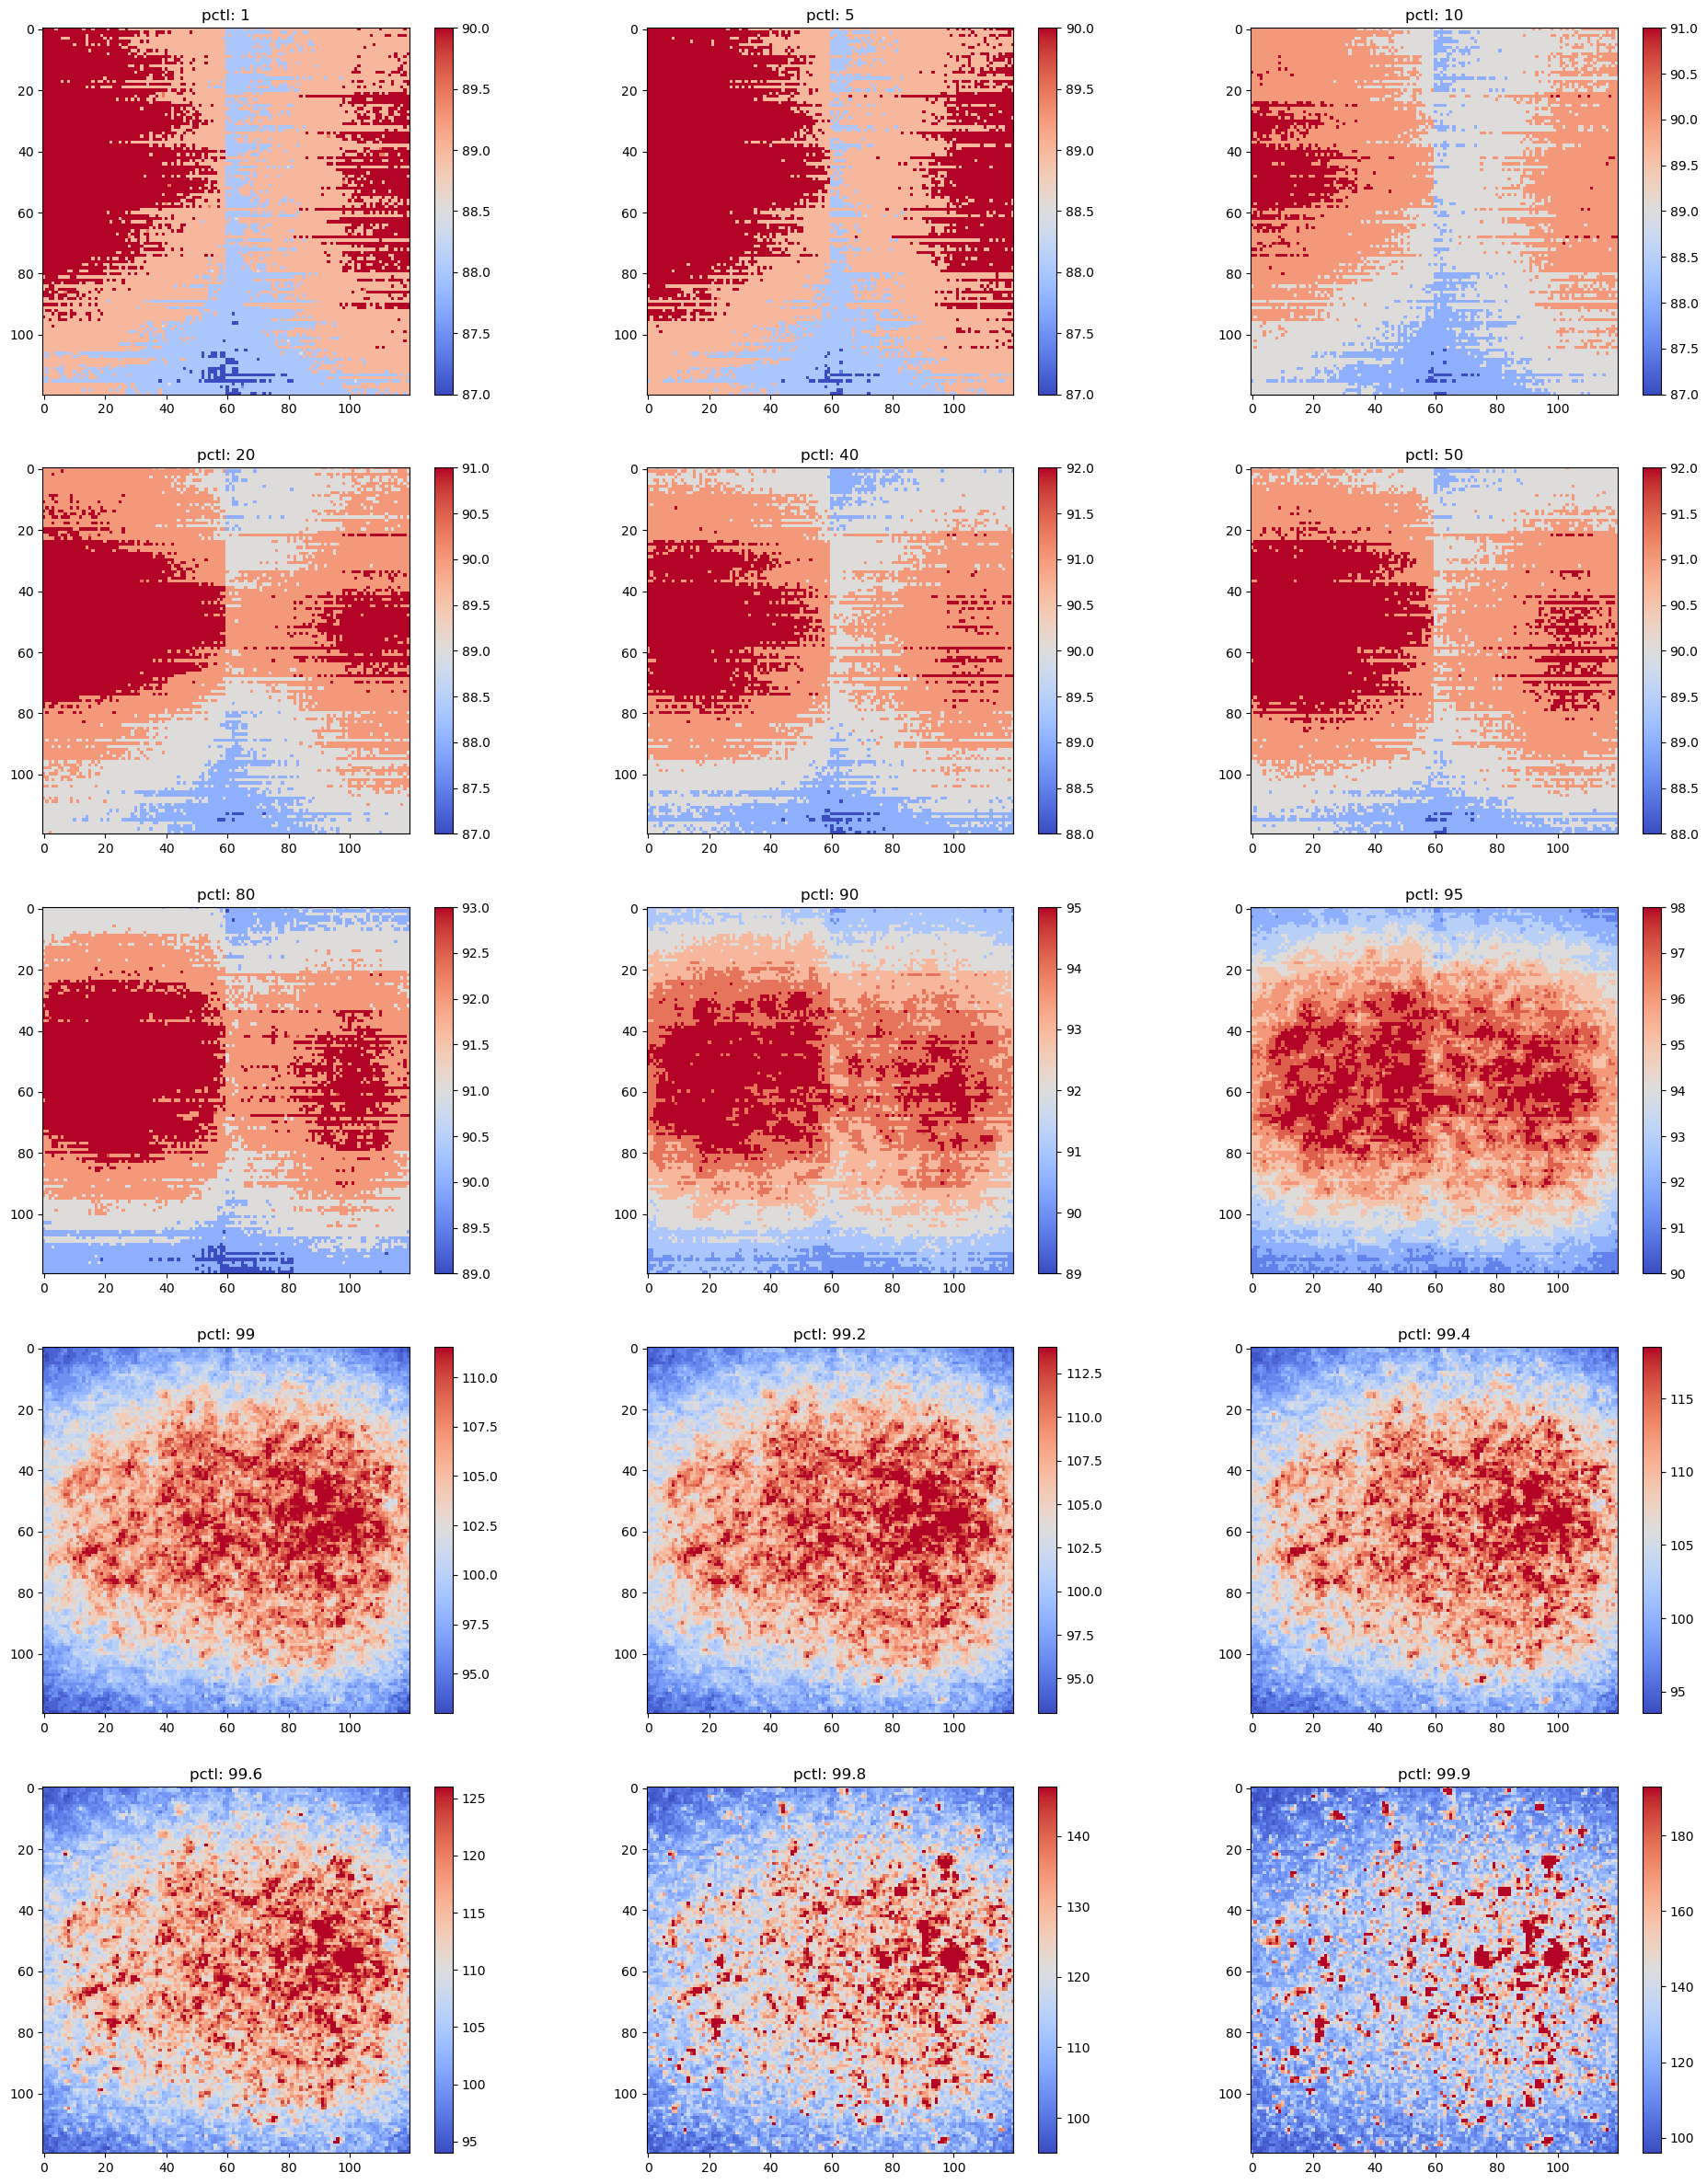

In [7]:
fig, axs = plt.subplots(5,3, figsize=(3*8,5*6))
for ax, pctl, vec in zip(axs.flat, pctls, vects): 
    vmax = np.percentile(vec, 95)
    vmin = np.percentile(vec,  5)
    g = ax.imshow(vec, cmap='coolwarm', vmax=vmax)
    ax.set_title(f'pctl: {pctl}')
    fig.colorbar(g)

plt.show()

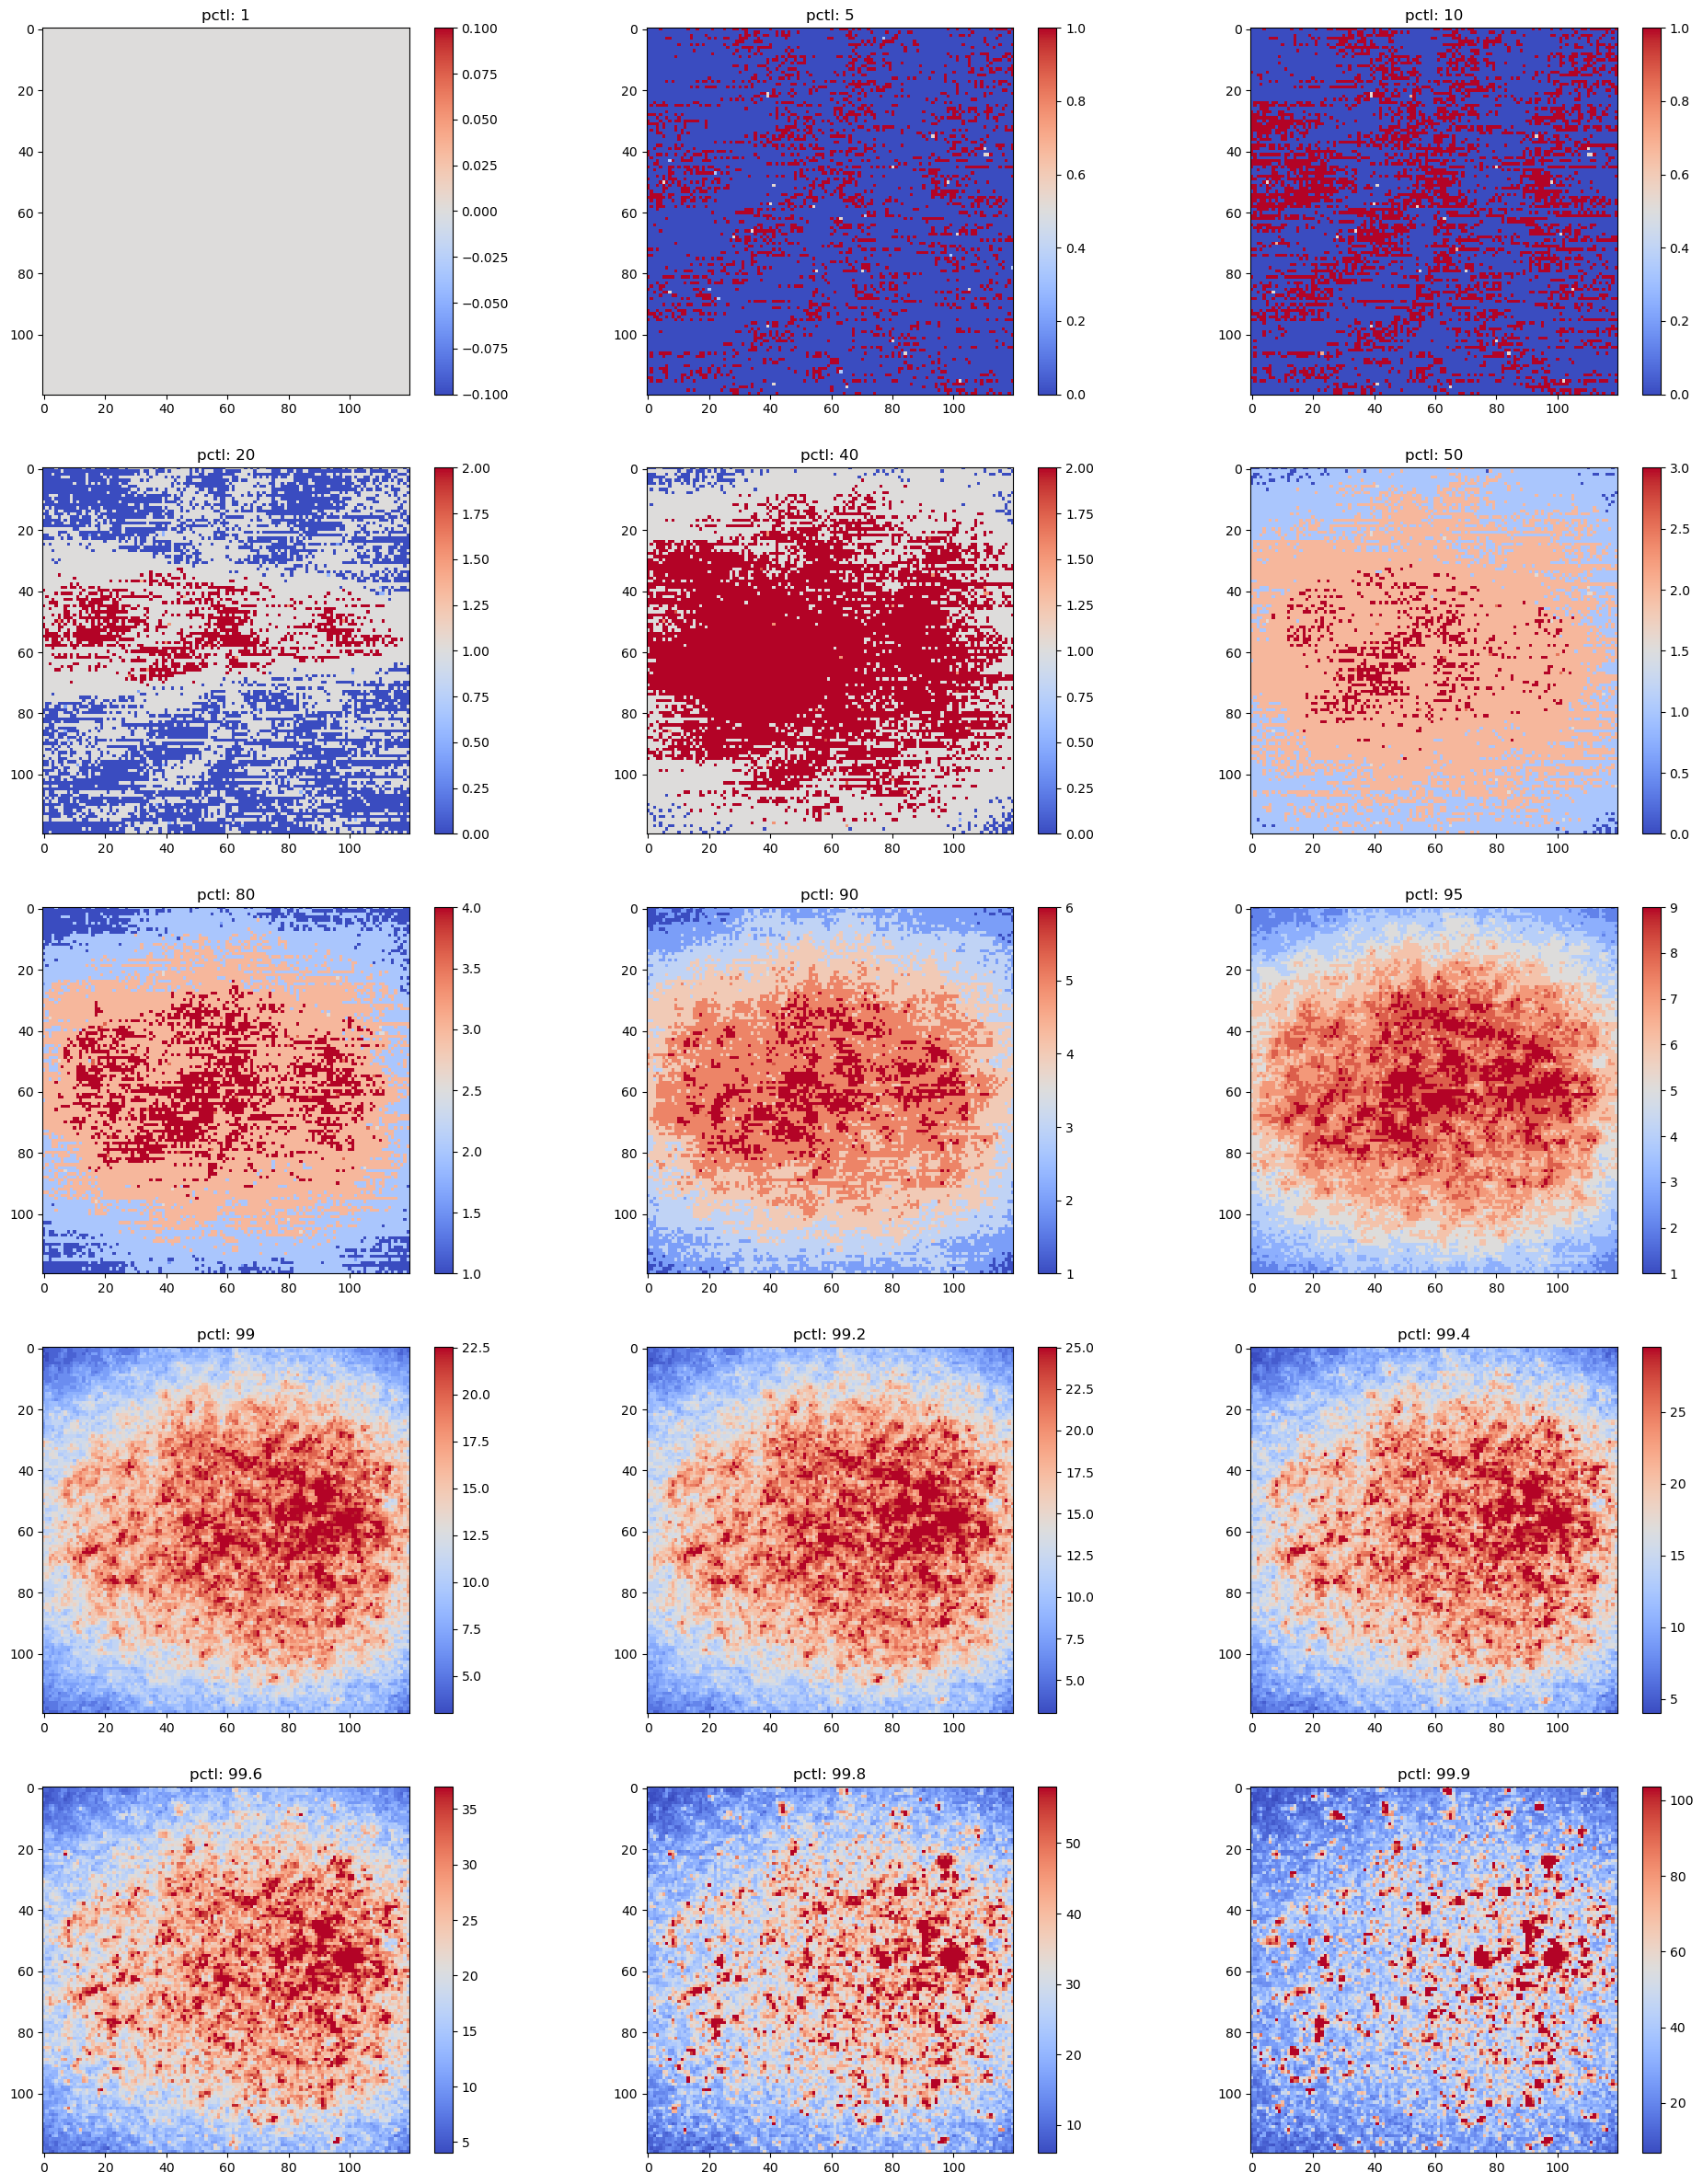

In [8]:
fig, axs = plt.subplots(5,3, figsize=(3*8,5*6))
for ax, pctl, vec in zip(axs.flat, pctls, vects): 
    vec = vec - vects[0]
    vmax = np.percentile(vec, 95)
    vmin = np.percentile(vec,  5)
    g = ax.imshow(vec, cmap='coolwarm', vmax=vmax)
    ax.set_title(f'pctl: {pctl}')
    fig.colorbar(g)
plt.show()

In [9]:
# correct it

In [10]:
# images = zarr_data[f'/setup13/timepoint0/s4'][...]
images = images_raw.copy()
dx = np.percentile(images,1, axis=0)
images = np.clip(images.astype(np.float16) - dx, 0, 1000).astype(np.uint16)

100
13.647666931152344


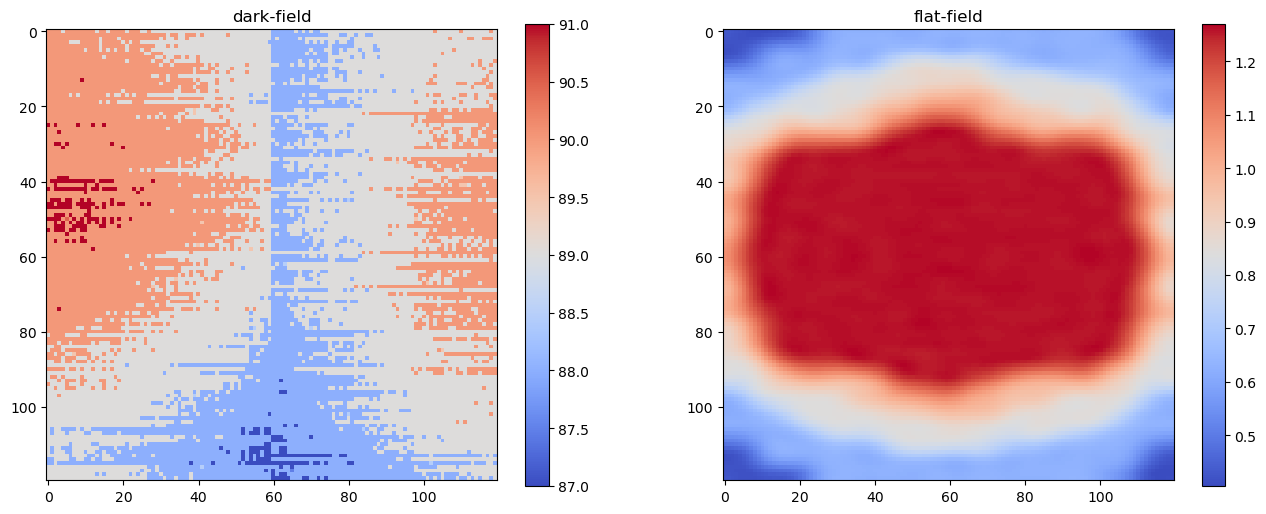

200
34.28662347793579


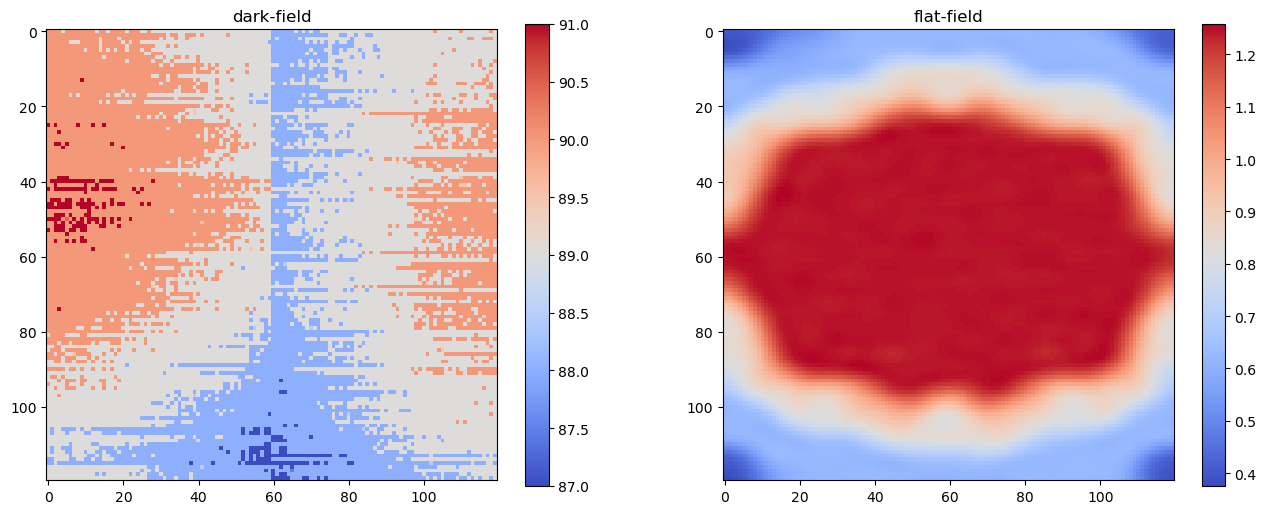

400
71.08451199531555


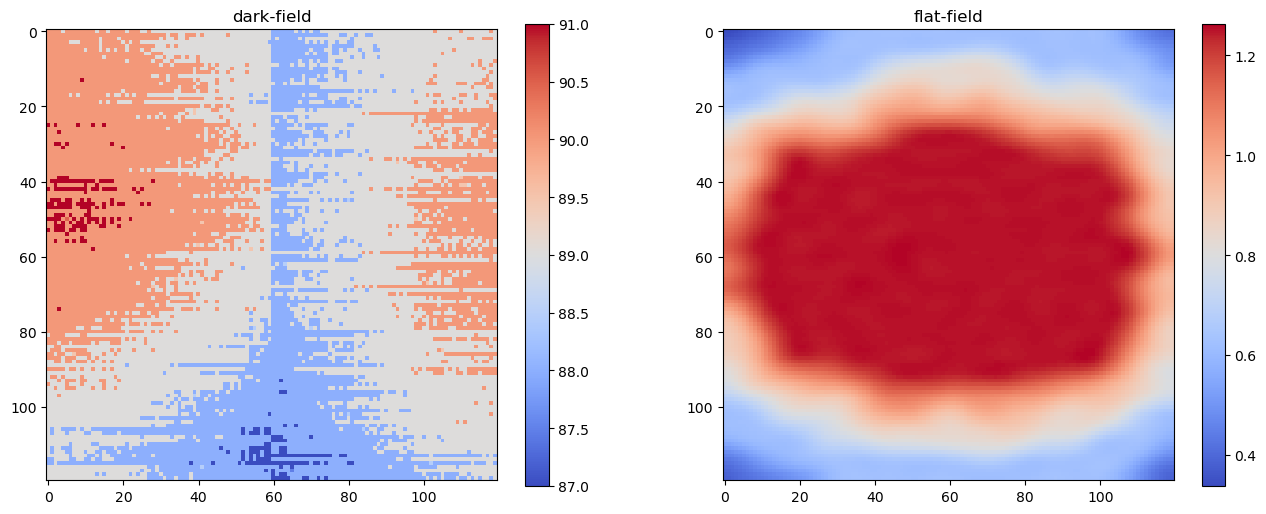

800
124.7464427947998


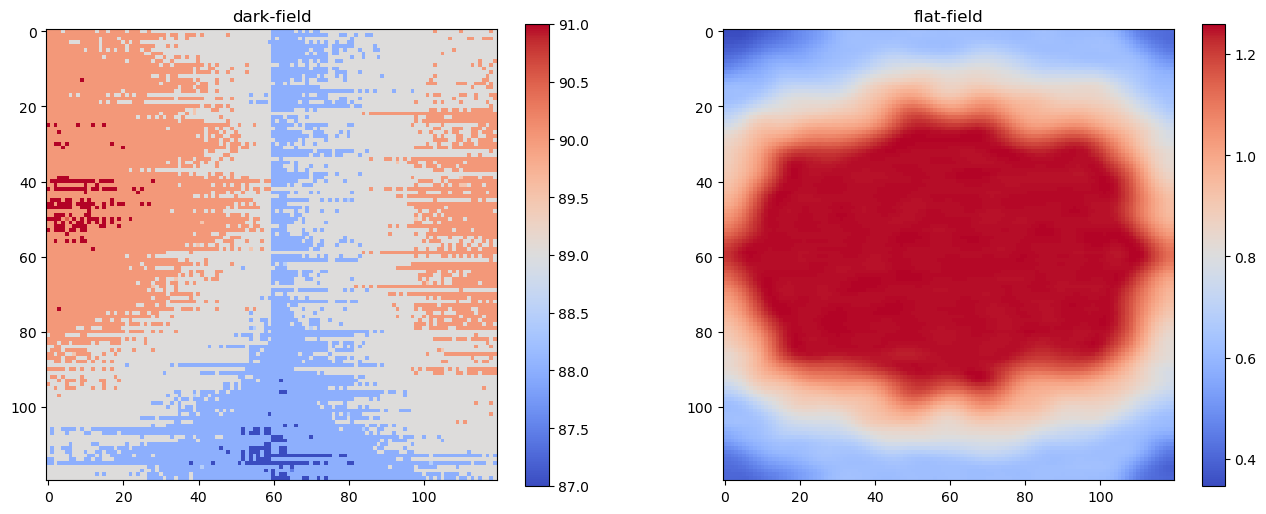

1600
342.75225377082825


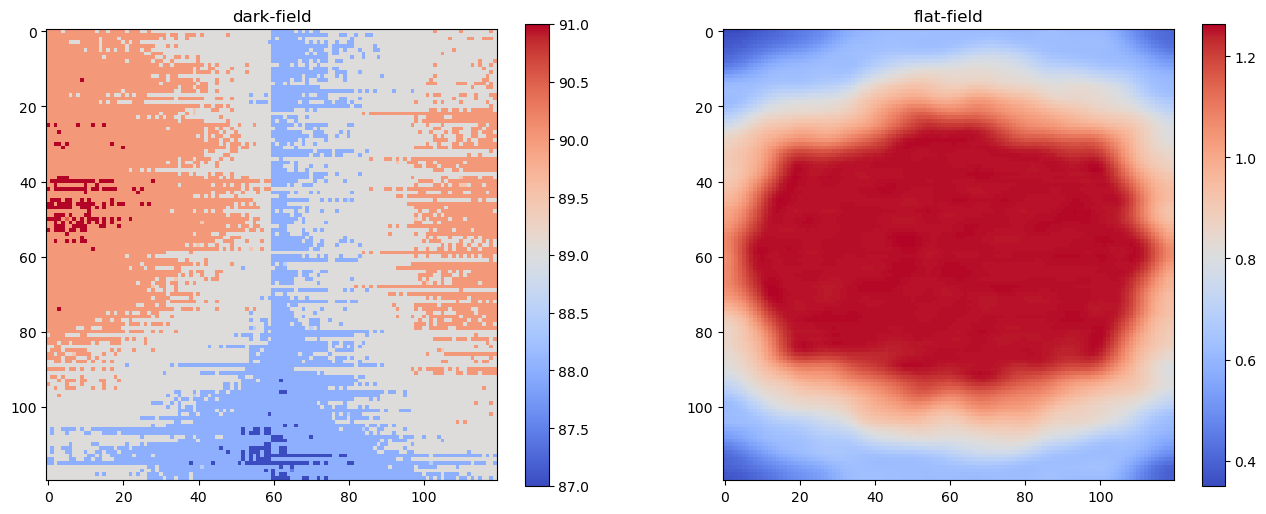

4248



KeyboardInterrupt



In [17]:
%%time
import time

np.random.seed(0)

for n in [100, 200, 400, 800, 1600, len(images)]:
    ti = time.time()
    print(n)
    
    idx = np.random.choice(len(images), n, replace=False)
    basic = BaSiC(get_darkfield=False, smoothness_flatfield=1, working_size=None, sort_intensity=True)
    basic.fit(images[idx])
    
    ff = basic.flatfield
    
    print(time.time()-ti)
    
    fig, axs = plt.subplots(1,2,figsize=(8*2, 6))
    ax = axs[0]
    g = ax.imshow(dx, cmap='coolwarm') #, vmin=0, vmax=2)
    ax.set_title('dark-field')
    plt.colorbar(g)
    ax = axs[1]
    g = ax.imshow(ff, cmap='coolwarm',) # vmid=1) # vmin=0, vmax=2)
    ax.set_title('flat-field')
    fig.colorbar(g)
    plt.show()
    

In [19]:
import tifffile
outdir = '/u/home/f/f7xiesnm/project-zipursky/easifish/results/sparse06_r1c0_flatfield'
!mkdir -p $outdir

tifffile.imwrite(outdir+'/darkfield_bs.tiff', dx)
tifffile.imwrite(outdir+'/flatfield_bs.tiff', ff)

In [20]:
!ls $outdir
dx = tifffile.imread(outdir+'/darkfield_bs.tiff')
ff = tifffile.imread(outdir+'/flatfield_bs.tiff')
dx, ff

darkfield_bs.tiff  darkfield.tiff     flatfield_rb.tiff
darkfield_rb.tiff  flatfield_bs.tiff  flatfield.tiff


(array([[90., 90., 90., ..., 89., 90., 89.],
        [90., 90., 90., ..., 89., 89., 89.],
        [90., 90., 90., ..., 90., 90., 89.],
        ...,
        [89., 89., 89., ..., 89., 89., 89.],
        [89., 89., 89., ..., 89., 89., 89.],
        [89., 89., 89., ..., 89., 88., 89.]]),
 array([[0.3501931 , 0.35045448, 0.35129836, ..., 0.4141304 , 0.41093972,
         0.40929544],
        [0.3608034 , 0.36109662, 0.36196393, ..., 0.41581628, 0.41221976,
         0.41036007],
        [0.36899883, 0.36948922, 0.37067363, ..., 0.41779265, 0.4133917 ,
         0.4111093 ],
        ...,
        [0.38863057, 0.3895593 , 0.39155436, ..., 0.4048407 , 0.3991764 ,
         0.39629745],
        [0.3783137 , 0.3790164 , 0.38061532, ..., 0.4002871 , 0.3950345 ,
         0.3923604 ],
        [0.37437847, 0.37495914, 0.37634054, ..., 0.4000777 , 0.3951809 ,
         0.39268392]], dtype=float32))